In [1]:
from app.dotenv import base_dir, data_dir
from app.model.model import  Model
import os

In [2]:
print('dotenv params:', {os.getenv('PARAM1')})
print('base_dir:', base_dir)
print('data_dir:', data_dir)

model = Model()
print('model:', model)

dotenv params: {'PARAM1_value'}
base_dir: c:\Users\yili0901\Downloads\code\identify_static_video_changes\app
data_dir: c:\Users\yili0901\Downloads\code\identify_static_video_changes\data
model: loaded Model


In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt




def loadFrames( save_path1="frame1.png", save_path2="frame2.png"):


    # Load the images back using matplotlib
    frame1_rgb = plt.imread(save_path1)
    frame2_rgb = plt.imread(save_path2)
    
    frame1_rgb = (frame1_rgb*255).astype(np.uint8)
    frame2_rgb = (frame2_rgb*255).astype(np.uint8)
    

    # Convert the RGB frames to grayscale
    prvs_gray = cv.cvtColor(frame1_rgb, cv.COLOR_RGB2GRAY)
    next_gray = cv.cvtColor(frame2_rgb, cv.COLOR_RGB2GRAY)


    return prvs_gray, next_gray, frame1_rgb, frame2_rgb




# Define the data directory (adjust the path as needed)
# data_dir = "/path/to/your/video/directory"

def saveVideoFrames(video_dir,save_path1, save_path2):
    # Open the video file
    cap = cv.VideoCapture(cv.samples.findFile(video_dir))
    # Read the first frame
    ret, frame1 = cap.read()
    if not ret:
        print('No frames grabbed!')
        cap.release()
        exit()
    # Read the second frame    
    ret, frame2 = cap.read()
    if not ret:
        print('No second frame grabbed!')
        cap.release()
        exit()    
    # Release the video capture object
    cap.release()
    # ----------------------
    # images are loaded in bgr format - Convert frames from BGR to RGB
    



    
    # Save the frames as image files
    cv.imwrite(save_path1, frame1)  
    cv.imwrite(save_path2, frame2)  
    



In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt






def loadVideoFrames():
    # Open the video file
    cap = cv.VideoCapture(cv.samples.findFile(f"{data_dir}/vtest.avi"))
    # Read the first frame
    ret, frame1 = cap.read()
    if not ret:
        print('No frames grabbed!')
        cap.release()
        exit()
    # Read the second frame    
    ret, frame2 = cap.read()
    if not ret:
        print('No second frame grabbed!')
        cap.release()
        exit()    
    # Release the video capture object
    cap.release()
    # ----------------------
    # images are loaded in bgr format - Convert frames from BGR to RGB
    

    frame1_rgb = cv.cvtColor(frame1, cv.COLOR_BGR2RGB)
    frame2_rgb = cv.cvtColor(frame2, cv.COLOR_BGR2RGB)
    # Convert the RGB frames to grayscale
    prvs_gray = cv.cvtColor(frame1_rgb, cv.COLOR_RGB2GRAY)
    next_gray = cv.cvtColor(frame2_rgb, cv.COLOR_RGB2GRAY)

    

    
    # Return the grayscale frames for optical flow and RGB frames for display
    return prvs_gray, next_gray, frame1_rgb, frame2_rgb




# prvs_gray, next_gray, prvs_rgb, next_rgb = loadVideoFrames()
saveVideoFrames(video_dir = f"{data_dir}/vtest.avi",save_path1 = f"{data_dir}/frame1.png", save_path2= f"{data_dir}/frame2.png")
prvs_gray, next_gray, prvs_rgb, next_rgb = loadFrames(save_path1 = f"{data_dir}/frame1.png", save_path2= f"{data_dir}/frame2.png")






In [5]:
def opticalFlow(prvs, next):
    '''
    input:  prvs - grayscale frame 1, range [0, 255]
            next - grayscale frame 2, range [0, 255]
    output: OpticalFlow_rgb - optical flow visualization in RGB format, range [0, 255]
            OpticalFlow_gray - optical flow visualization in grayscale format, range [0, 255]
    '''
    
    # Compute optical flow between the prvs and next frames
    flow = cv.calcOpticalFlowFarneback(prvs, next, flow=None, pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    # Convert the flow to magnitude and angle
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])

    # Visualize the flow in HSV format
    # hsv = np.zeros_like(frame1)
    hsv = np.zeros((prvs.shape[0], prvs.shape[1], 3),dtype='uint8')
    hsv[..., 1] = 255               # Full saturation (maximum) i.e full color intensity.
    hsv[..., 0] = ang * 180 / np.pi / 2 # Direction in the range [0, 180]
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX) # Normalized magnitude in the range [0, 255]

    # Convert the HSV image to BGR for display
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    OpticalFlow_rgb = cv.cvtColor(bgr, cv.COLOR_BGR2RGB)
    OpticalFlow_gray = cv.cvtColor(OpticalFlow_rgb, cv.COLOR_RGB2GRAY)
    return OpticalFlow_rgb,OpticalFlow_gray

OpticalFlow_rgb,OpticalFlow_gray = opticalFlow(prvs_gray, next_gray)    


In [6]:
def detectAndCropROIs(thresh,image, min_area=2000, max_area=20000):
    '''
    Detect regions of interest (ROIs) based on contours in the given image.
    The function assumes that the regions are distinguishable based on intensity.

    input:  image - The image in which to detect the regions (grayscale or optical flow result)
            min_area - Minimum area of contours to consider as regions (default 1000 pixels)
            max_area - Maximum area of contours to consider as regions (default 10000 pixels)
    output: roi_coords - List of tuples containing (y1, x1, y2, x2) coordinates for each ROI
            cropped_regions - List of cropped images corresponding to each detected region
    '''
    
    # # Step 1: Convert the image to grayscale if it is not already
    # if len(image.shape) == 3:
    #     gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    # else:
    #     gray = image
    
    # # Step 2: Threshold the image to get a binary mask (regions of interest)
    # _, thresh = cv.threshold(gray, 1, 255, cv.THRESH_BINARY)
    
    # Step 3: Find contours in the thresholded image
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    roi_coords = []
    cropped_regions = []
    
    # Step 4: Filter contours based on area and extract bounding boxes
    for contour in contours:
        area = cv.contourArea(contour)
        if not (min_area <= area <= max_area):
            continue
        # Get bounding box (x, y, width, height)
        x, y, w, h = cv.boundingRect(contour)
        roi_coords.append((y, x, y + h, x + w))  # (top_left_y, top_left_x, bottom_right_y, bottom_right_x)
        
        # # Crop the region from the original image
        cropped_region = image[y:y + h, x:x + w]
        cropped_regions.append(cropped_region)
    
    return roi_coords,cropped_regions


# roi_coords, cropped_regions = detectAndCropROIs(OpticalFlow_rgb)



# # ---------------------------

# import numpy as np
# import cv2 as cv
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

def adaptiveThresh(image, thresh_type = 0):
    # Step 1: Convert the image to grayscale if it is not already
    if len(image.shape) == 3:
        gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    else:
        gray = image
    
    if thresh_type == 0:
        # Step 2: Threshold the image to get a binary mask (regions of interest)
        _, thresh = cv.threshold(gray, 1, 255, cv.THRESH_BINARY)
    else:
        
        # Step 2: Apply Gaussian blur to reduce noise
        blurred = cv.GaussianBlur(gray, (5, 5), 0)
        
        # Step 3: Threshold the image using adaptive thresholding
        thresh = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv.THRESH_BINARY, 11, 2)
    
    

    
    # # --- Debug: Show the thresholded image ---
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(thresh, cmap='gray')
    # plt.title('Thresholded Image')
    # plt.axis('off')
    
    return thresh


adaptiveThreshold = adaptiveThresh(OpticalFlow_gray,thresh_type=0)
roi_coords,cropped_regions = detectAndCropROIs(adaptiveThreshold,OpticalFlow_rgb)



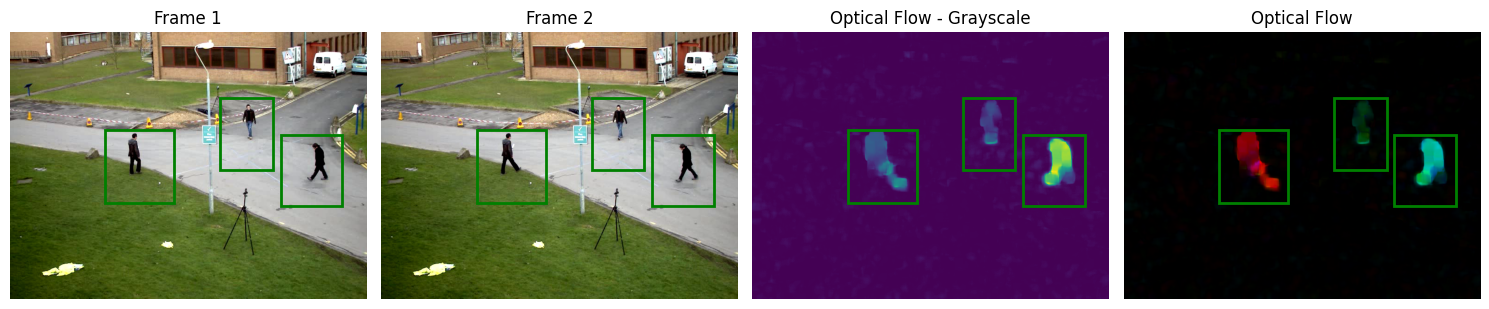

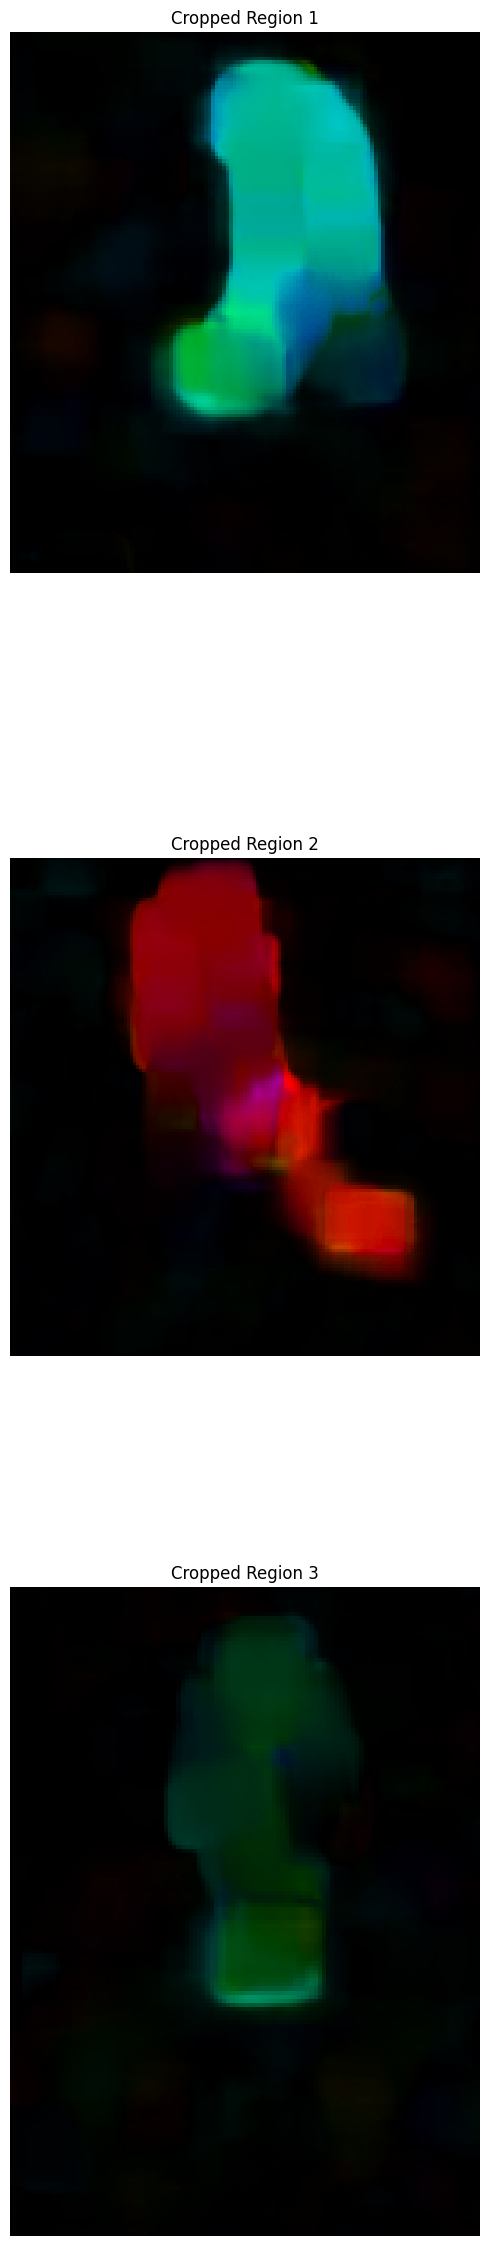

In [7]:
import matplotlib.patches as patches
def plotOpticalFlowWithROIs(prvs_rgb, next_rgb, OpticalFlow_rgb, OpticalFlow_gray, roi_coords):
    '''
    input:  prvs_rgb - frame 1 in RGB format, range [0, 255]
            next_rgb - frame 2 in RGB format, range [0, 255]
            OpticalFlow_rgb - optical flow visualization in RGB format, range [0, 255]
            OpticalFlow_gray - optical flow visualization in grayscale format, range [0, 255]
            roi_coords - List of tuples containing (y1, x1, y2, x2) coordinates for each detected ROI
            cropped_regions - List of cropped images corresponding to each detected region
    output: None
    '''
    # Create a figure with multiple subplots for each ROI
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    
    # Plot the full frames and optical flow result
    axes[0].imshow(prvs_rgb)  
    axes[0].set_title('Frame 1')
    axes[0].axis('off')

    axes[1].imshow(next_rgb) 
    axes[1].set_title('Frame 2')
    axes[1].axis('off')

    axes[2].imshow(OpticalFlow_gray)  
    axes[2].set_title('Optical Flow - Grayscale')
    axes[2].axis('off')

    axes[3].imshow(OpticalFlow_rgb)  
    axes[3].set_title('Optical Flow')
    axes[3].axis('off')
    
    # for idx, (cropped, coords) in enumerate(zip(cropped_regions, roi_coords)):
    #     y1, x1, y2, x2 = coords
    #     cv.rectangle(OpticalFlow_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Draw rectangles around the regions of interest in the OpticalFlow_rgb image
    for i in range(len(axes)):
        for idx, (coords) in enumerate(roi_coords):
            y1, x1, y2, x2 = coords
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none')
            axes[i].add_patch(rect)  # Adding rectangle to OpticalFlow image
    plt.tight_layout()
    plt.show()
    
def plotCrop(cropped_regions,coords):
    
    fig, axes = plt.subplots(len(roi_coords), 1, figsize=(5, 25))

    # Plot cropped regions
    for idx, (cropped, coords) in enumerate(zip(cropped_regions, roi_coords)):
        axes[idx].imshow(cropped)
        axes[idx].set_title(f'Cropped Region {idx + 1}')
        axes[idx].axis('off')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
plotOpticalFlowWithROIs(prvs_rgb, next_rgb, OpticalFlow_rgb, OpticalFlow_gray, roi_coords)
plotCrop(cropped_regions,roi_coords)
